In [1]:
import numpy as np
import cv2
import os
import pandas as pd
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
%matplotlib inline
import time
import re
from sqlalchemy import create_engine
from sqlalchemy import Table
from sqlalchemy import Column
from sqlalchemy import MetaData
from sqlalchemy.dialects.postgresql import BYTEA
from sqlalchemy import Integer,String
from sqlalchemy import select
import pickle
import random
import itertools
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

##Sklearn (Model Imports)
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC
import sklearn
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from Convert_To_Num import convert_wrapper,convert_series_to_float,convert_series_to_int

# Connect Engine To SQL

In [4]:
engine_aws = create_engine('postgresql://**ec2IP**5432/project03',echo=False)
meta = MetaData(engine_aws)

# Create Pixel Image DF And Clean Data

In [5]:
col=[]
for i in range(1,1801):
    col=np.append(col,'P'+str(i))

col=np.append(col,"Class")
col = tuple(col)

In [6]:
conn = engine_aws.connect()
pixel_data=Table('pixel_data',meta,autoload=True,schema='public')
select_st = pixel_data.select()
res = conn.execute(select_st)
temp_list=[]
count=0
for _row in res:
    count+=1
    if count%1000==0:
        print(count)
    image_list=[]
    image_list=np.append(image_list,np.array(list(_row[1])))
    image_list=tuple(np.append(image_list,_row[2].lower()))
    dict_temp={col[i]:image_list[i] for i in range(0,len(col))}
    temp_list.append(dict_temp)
    
df_pix=pd.DataFrame(temp_list)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
HERE


In [7]:
convert_series_to_int(df_pix)

In [8]:
df_pix=pd.get_dummies(df_pix,columns=['Class'],prefix='class',drop_first=True)

# Create Moment Image DF And Clean Data

In [9]:
conn=engine_aws.connect()
moment_data=Table('moment_data',meta,autoload=True,schema='public')
select_mom=moment_data.select()

In [10]:
df_moment=pd.read_sql(select_mom,con=conn)

In [11]:
df_moment.drop(columns=['index'],inplace=True)

In [12]:
convert_series_to_float(df_moment)

In [13]:
df_moment=pd.get_dummies(df_moment,columns=['Class'],prefix='class',drop_first=True)

In [15]:
df_pix.shape

(35431, 1801)

# Pull in Both Models

In [16]:
pixel_model=pickle.load(open('RF_Pix_Model.p','rb'))

In [17]:
moment_model=pickle.load(open('RF_Moment_Model.p','rb'))

# Split Data For Models - And Clean Out Data
**Tried Logistic Regression, SVM Classifier, NB AND RF - Logistic Regression Worked Best**

In [18]:
y = np.array(df_pix['class_normal'])
X_pix = np.array(df_pix.drop(columns=['class_normal']))
X_moment = np.array(df_moment.drop(columns=['class_normal']))

In [19]:
y =np.reshape(y,(35431,1))

In [20]:
random_number=int(random.random()*10000)

In [21]:
X_pix_train,X_pix_test,y_train,y_test=train_test_split(X_pix,y,test_size=.2,random_state=random_number,stratify=y)
X_mom_train,X_mom_test,y_train,y_test=train_test_split(X_moment,y,test_size=.2,random_state=random_number,stratify=y)



# Logistic Regression

In [23]:
pixel_model

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
kf = StratifiedKFold(n_splits=3)
logit=LogisticRegression(n_jobs=-1)
for train,test in kf.split(X_mom_train,y_train):
    pixel_model.fit(X_pix_train[train],y_train[train])
    moment_model.fit(X_mom_train[train],y_train[train])
    
    pixel_pred_prob = pixel_model.predict_proba(X_pix_train[train])
    moment_pred_prob= moment_model.predict_proba(X_mom_train[train])
    df_pred_prob=pd.DataFrame(pixel_pred_prob[:,1],columns=['Pixel'])
    df_pred_prob['Moment']=moment_pred_prob[:,1]
    logit.fit(df_pred_prob,y_train[train])
    log_pred=logit.predict(df_pred_prob)
    print(f'AUC Score For Train: {roc_auc_score(y_train[train],log_pred)}')
    
    pixel_pred_prob_test = pixel_model.predict_proba(X_pix_train[test])
    moment_pred_prob_test= moment_model.predict_proba(X_mom_train[test])
    df_pred_prob_test=pd.DataFrame(pixel_pred_prob_test[:,1],columns=['Pixel'])
    df_pred_prob_test['Moment']=moment_pred_prob_test[:,1]
    log_pred=logit.predict_proba(df_pred_prob_test)
    print(f'AUC Score For Test: {roc_auc_score(y_train[test],log_pred[:,1])}')

KeyboardInterrupt: 

In [24]:
logit=LogisticRegression(n_jobs=-1)
pixel_model.fit(X_pix_train,y_train)
moment_model.fit(X_mom_train,y_train)

pixel_pred_prob_final_test = pixel_model.predict_proba(X_pix_train)
moment_pred_prob_final_test= moment_model.predict_proba(X_mom_train)

df_pred_prob_final=pd.DataFrame(pixel_pred_prob_final_test[:,1],columns=['Pixel'])
df_pred_prob_final['Moment']=moment_pred_prob_final_test[:,1]
logit.fit(df_pred_prob_final,y_train)
log_pred_final=logit.predict(df_pred_prob_final)
print(f'AUC Score For Train: {roc_auc_score(y_train,log_pred_final)}')

pixel_pred_prob_test_final = pixel_model.predict_proba(X_pix_test)
moment_pred_prob_test_final = moment_model.predict_proba(X_mom_test)
df_pred_prob_test=pd.DataFrame(pixel_pred_prob_test_final[:,1],columns=['Pixel'])
df_pred_prob_test['Moment']=moment_pred_prob_test_final[:,1]
log_pred=logit.predict_proba(df_pred_prob_test)
print(f'AUC Score For Test: {roc_auc_score(y_test,log_pred[:,1])}')

AUC Score For Train: 0.999882451356499
AUC Score For Test: 0.8100108451512367


In [25]:
pickle.dump(pixel_model,open('RF_Pix_Model.p','wb'))

In [22]:
pickle.dump(logit,open('Logistic_Ensemble_Model.p','wb'))

In [26]:
logit=pickle.load(open('Logistic_Ensemble_Model.p','rb'))

In [108]:
log_pred_pred=logit.predict(df_pred_prob_test[['Moment','Pixel']])

# Model Visuals And Graphing

## ROC Curve

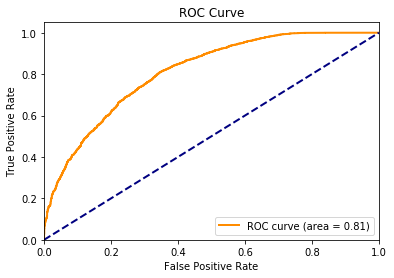

In [27]:
n_classes = 1
lw=2
fpr, tpr, _ = roc_curve(y_test, log_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkOrange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Precision/Recall Graph

(0, 1)

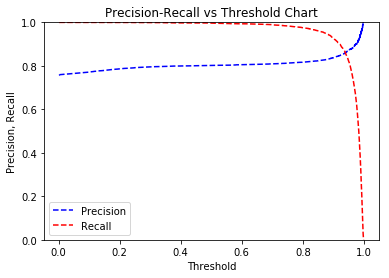

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, log_pred[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [45]:
## Apply Threshold
y_test_prob = pd.DataFrame(log_pred)
y_test_pred = y_test_prob.applymap(lambda x: 1 if x>.95 else 0)

## Confusion Matrix

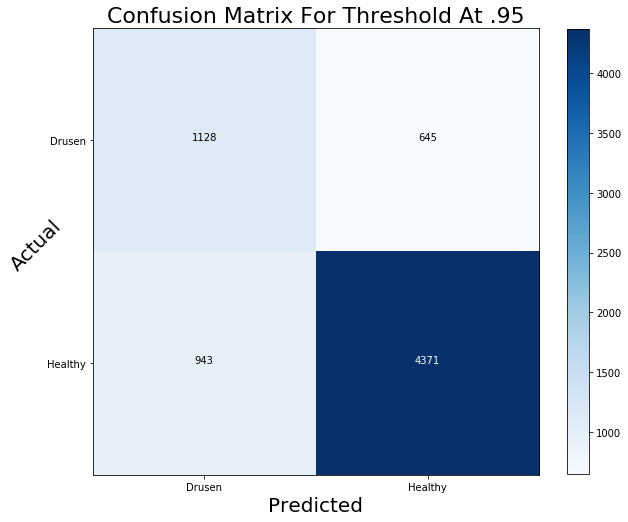

In [104]:
cnf_matrix = confusion_matrix(y_test,y_test_pred[1])
cnf_matrix
plt.rcParams["figure.figsize"]=(10,10)
plt.imshow(cnf_matrix,interpolation='nearest',cmap=plt.cm.Blues)
plt.title('Confusion Matrix For Threshold At .95',fontsize=22)
plt.colorbar(shrink=.82)
plt.xticks([0,1],['Drusen','Healthy'])
plt.yticks([0,1],['Drusen','Healthy'])
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('Actual',rotation=45,fontsize=20,)
fmt='d'
thresh = cnf_matrix.max() / 2
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
        

In [58]:
df_pred_prob_test['True_Y']=y_test
df_pred_prob_test["Observed Classes"]=y_test

In [71]:
df_pred_prob_test["Moments Model"]=df_pred_prob_test['Moment']
df_pred_prob_test["Pixelated Model"]=df_pred_prob_test['Pixel']

In [62]:
df_pred_prob_test["Observed Classes"]=df_pred_prob_test["Observed Classes"].map(lambda x: "Healthy" if (x ==1) else "Diseased")

In [68]:
for i in enumerate(sns.color_palette("colorblind", 2)):
    print(i)

(0, (0.00392156862745098, 0.45098039215686275, 0.6980392156862745))
(1, (0.8705882352941177, 0.5607843137254902, 0.0196078431372549))


## First Models Outputs

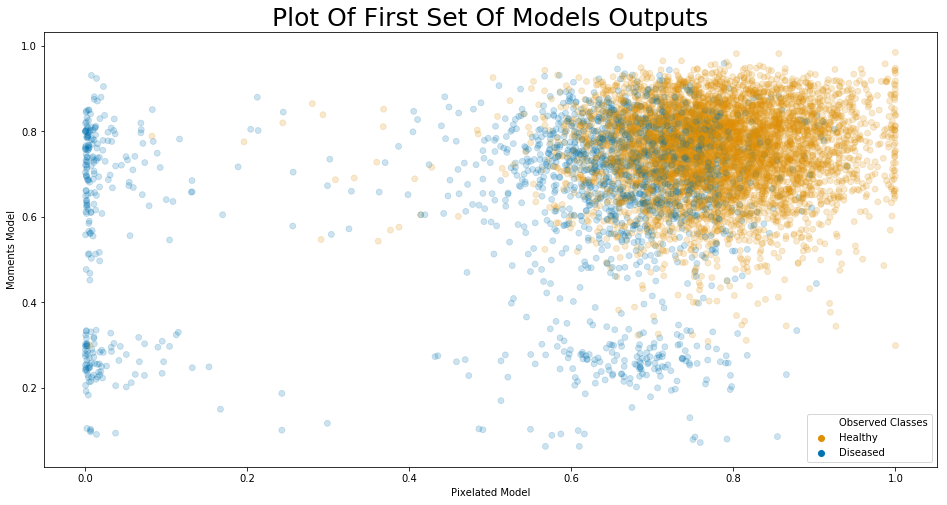

In [82]:
ens_plot=sns.scatterplot("Pixelated Model","Moments Model",data=df_pred_prob_test, hue="Observed Classes",palette=[(0.8705882352941177, 0.5607843137254902, 0.0196078431372549),(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),],
                alpha=.2, edgecolor=None)
plt.title('Plot Of First Set Of Models Outputs',fontsize=25)
plt.gcf().set_size_inches(16,8)

In [54]:
ens_plot.legend_.set_title('Observed Value')

In [34]:
X_pred_prob=np.array(df_pred_prob_test[['Pixel','Moment']])
y_true_prob=np.array(df_pred_prob_test['True_Y'])

## Decision Boundary

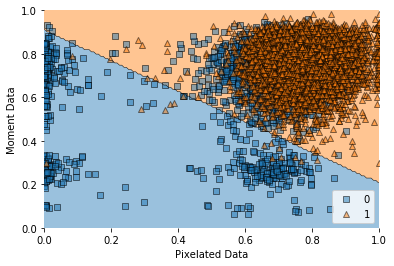

In [35]:
scatter_kwargs = {'alpha': 0.5}
scatter_highlight_kwargs = {'s': 1500, 'label': 'Test data', 'alpha': 1}
plot_decision_regions(X=X_pred_prob,y=y_true_prob,clf=logit,scatter_kwargs=scatter_kwargs,scatter_highlight_kwargs=scatter_highlight_kwargs)
plt.axis([0,1,0,1])
plt.xlabel('Pixelated Data')
plt.ylabel('Moment Data')
plt.legend(loc='lower right')

